# Generative Diffusion Model for MNIST Digits

In 2020, researchers from UC Berkeley released their paper *Denoising Diffusion Probabilistic Models* on a generative machine learning architecture called a diffusion model. (https://arxiv.org/abs/2006.11239)

<p align="center">
  <img src="images/diffusion_faces.png" alt="diffusion" width="600"/>
</p>

These models are based on nonequilibrium thermodynamics and seek to denoise images to create new realistic looking images.

## Imports

In [1]:
!pip install torchinfo

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import matplotlib as mpl
%matplotlib inline
import scipy
import os
import copy
from tqdm import tqdm#.notebook import tqdm
from time import time

import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision
from torch import linalg
from torchvision.transforms import ToTensor
import torchinfo

torch.set_default_dtype(torch.float64)
plt.rcParams["font.family"] = 'sans-serif'
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

# Get cpu or gpu device for training.
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


## Loading the Data: Let us begin with a simple example using MNIST digits

In [35]:
loaded_already = True

In [36]:
# Hyperparameters
batch_size = 32
image_size = 32

# Load MNIST dataset
transform = transforms.Compose([ transforms.Resize((image_size, image_size)), # resizes images
                                      transforms.ToTensor(), # Scales data into [0,1]
                                      transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
                                      ])

torch.manual_seed(0)
if loaded_already is not None:
  train_size = 1000
  train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
  # idx0 = torch.where(train_dataset.targets==0)[0]
  # idx1 = torch.where(train_dataset.targets==1)[0]
  # indxs = torch.cat([idx0,idx1])
  # train_dataset.targets = train_dataset.targets[indxs]
  # train_dataset.data = train_dataset.data[indxs]#/255.

  subset_indices = torch.randperm(len(train_dataset))[:train_size]
  subset_dataset = torch.utils.data.Subset(train_dataset, subset_indices)
  train_loader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)

  # test_size = 100
  # test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
  # subset_indices = torch.randperm(len(test_dataset))[:test_size]
  # subset_dataset = torch.utils.data.Subset(test_dataset, subset_indices)
  # test_loader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)

  loaded_already = None

Feature batch shape: torch.Size([32, 1, 32, 32])
Labels batch shape: torch.Size([32])


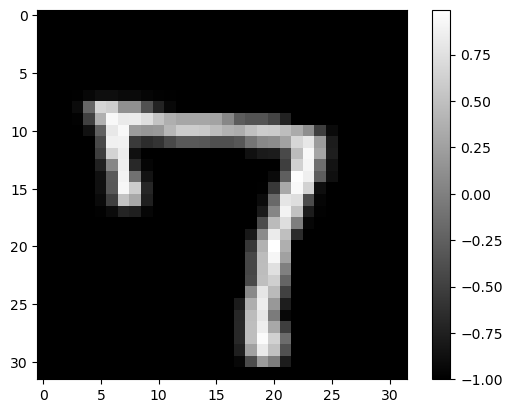

Label: 7


In [37]:
torch.manual_seed(0)
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# test_features, test_labels = next(iter(test_loader))

img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap='gray')
plt.colorbar()
plt.show()
print(f"Label: {label}")

## Setting up the Model

Components of the Diffusion Model:



1.   **Forward Noising Process:** This is a stochastic markov process which adds scheduled noise to the images sequentially depending on the previous image's state. We can express the noised image at time step $t$ by
$$q(x_t | x_{t-1}) = N(\sqrt{1- \beta_t}x_{t-1}, \sqrt{\beta_t}I) =  \sqrt{1- \beta_t}x_{t-1}+ \sqrt{\beta_t}\varepsilon $$
where $\varepsilon$ is the sampled noise from a normal distribution with a mean of zero and standard deviation about the identity, , i.e. $N(0,I)$, times the square root of $\beta_t$. The number of total time steps $T$ and the range of the $\beta$'s are hyperparameters chosen by the user. Typically, $\beta \in [10^{-4},0.02]$ and $T=1000$. One can precompute the noised image at any time step by using
$$x_t(x_0,\varepsilon) = \sqrt{\prod_{i=1}^t \alpha_i} x_0 + \sqrt{1-\prod_{i=1}^t \alpha_i} \varepsilon$$
where $\alpha_i = 1-\beta_i$.


2.   **Backwards Parameterized Denoising Process (U-Net):** A neural networks with learnable parameters to recover the original images from the diffused ones with noise. This architecture is typically a U-Net which is a convolutional neural network with convolutional layers to decrease the feature size (down layers) and convolutional transpose layers to increase the feature size (up layers). See the discussion section for how the convolutional transpose function works in practice.




In [38]:
# torch.autograd.set_detect_anomaly(True)
# U-Net model
class UNet(nn.Module):
    def __init__(self, time_emb_dim):
        super(UNet, self).__init__()
        # Encoders
        self.enc1 = nn.Conv2d(in_channels = 1, out_channels = time_emb_dim, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(in_channels = time_emb_dim,out_channels = time_emb_dim, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(in_channels = time_emb_dim,out_channels = time_emb_dim*2, kernel_size=3, padding=1)
        self.enc4 = nn.Conv2d(in_channels = time_emb_dim*2,out_channels = time_emb_dim*2, kernel_size=3, padding=1)
        self.enc5 = nn.Conv2d(in_channels = time_emb_dim*2,out_channels = time_emb_dim*4, kernel_size=3, padding=1)
        # Decoders
        self.dec1 = nn.ConvTranspose2d(in_channels = time_emb_dim*4, out_channels = time_emb_dim*2, kernel_size=3, padding=1)
        self.dec2 = nn.ConvTranspose2d(in_channels = time_emb_dim*2, out_channels = time_emb_dim*2, kernel_size=3, padding=1)
        self.dec3 = nn.ConvTranspose2d(in_channels = time_emb_dim*2, out_channels = time_emb_dim, kernel_size=3, padding=1)
        self.dec4 = nn.ConvTranspose2d(in_channels = time_emb_dim, out_channels = time_emb_dim, kernel_size=3, padding=1)
        self.dec5 = nn.ConvTranspose2d(in_channels = time_emb_dim, out_channels = 1, kernel_size=3, padding=1)

        # further time MLPs
        self.time_mlp1 = nn.Sequential(nn.Linear(time_emb_dim, time_emb_dim*2),nn.ReLU())
        self.time_mlp2 = nn.Sequential(nn.Linear(time_emb_dim*2, time_emb_dim*2),nn.ReLU())
        self.time_mlp3 = nn.Sequential(nn.Linear(time_emb_dim*2, time_emb_dim),nn.ReLU())

    def forward(self, x, time):
        # Apply the encoders followed by the decoders
        '''
        Encoder 1: Block 1
        '''
        x = F.relu(self.enc1(x))
        x = x + time[None,:,None,None].to(device)
        # x = F.max_pool2d(input = x, kernel_size = 2)
        # 2
        x = F.relu(self.enc2(x))
        # Max pooling on the way down to a new block
        x = F.max_pool2d(input = x, kernel_size = 2)

        '''
        Encoder 2: Block 2
        '''
        # 3
        x = F.relu(self.enc3(x))
        # x = F.max_pool2d(input = x, kernel_size = 2)
        time = self.time_mlp1(time.to(device))
        x = x + time[None,:,None,None]
        # 4
        x = F.relu(self.enc4(x))
        # x = F.max_pool2d(input = x, kernel_size = 2)
        # 5
        x = F.relu(self.enc5(x))
        x = F.max_pool2d(input = x, kernel_size = 2)

        # Interpolation on the way up to next block
        x = F.interpolate(x, scale_factor=2)
        '''
        Decoder 1: Block 3
        '''
        x = F.relu(self.dec1(x))
        time = self.time_mlp2(time)
        x = x + time[None,:,None,None]
        # 2
        x = F.relu(self.dec2(x))
        # x = F.interpolate(x, scale_factor=2)
        # 3
        x = F.relu(self.dec3(x))
        x = F.interpolate(x, scale_factor=2)

        '''
        Decoder 2: Block 4
        '''
        # 4
        x = F.relu(self.dec4(x))
        time = self.time_mlp3(time)
        x = x + time[None,:,None,None]
        # x = F.interpolate(x, scale_factor=2)
        x = F.relu(self.dec5(x))
        # x = F.interpolate(x, scale_factor=2)
        return x

# Forward Diffusion Noising Process
class forward_noise(nn.Module):
    def __init__(self):
        super(forward_noise, self).__init__()

    def forward(self, x, T, t, betas):
        noise = torch.randn_like(x)
        alphas = 1. - betas # defining alpha vector
        alphas_cumprod = torch.cumprod(alphas, axis=0)  # cumulative product vector of the same size
        sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
        sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
        # for t in range(T):
        #     noise = torch.randn_like(x)
        #     x = torch.sqrt(1 - betas[t]) * x + torch.sqrt(betas[t]) * noise
        x = sqrt_alphas_cumprod[t]*x + sqrt_one_minus_alphas_cumprod[t]*noise
        return x, noise

# Embedding for the beta at time step t. Rememeber beta affects both the mean and variance of the modified image
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        half_dim = self.dim // 2
        embeddings = torch.log(torch.tensor([10000])) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time*embeddings[None, :]
        embeddings = torch.cat((embeddings.cos(),embeddings.sin()), dim=-1)
        return embeddings

# Diffusion model
class DiffusionModel(nn.Module):
    def __init__(self, unet, forward_noise, T, time_emb_dim):
        super(DiffusionModel, self).__init__()
        self.unet = unet
        self.forward_noise = forward_noise
        self.T = T
        self.betas = torch.linspace(1e-4, 0.02, T)
        # Time embedding
        self.time_emb_dim = time_emb_dim
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(self.time_emb_dim),
                nn.Linear(self.time_emb_dim, self.time_emb_dim),
                nn.ReLU(),
                nn.Linear(self.time_emb_dim, self.time_emb_dim),
                nn.ReLU())

    def forward(self, x, t):
        # print('Check input shape',x.shape)
        # Forward diffusion process
        x, noise = self.forward_noise(x,self.T,t,self.betas)
        # print('Check middle shape',x.shape)
        # Reverse diffusion process
        # t = self.betas[t]
        time = self.time_mlp(t.type(torch.float64))[0]/self.T
        predicted_noise = self.unet(x,time)  # Predict data
        # for t in reversed(range(self.T)):
        #     x = self.unet(x)  # Predict data

        # print('Check output shape',x.shape)
        return predicted_noise, noise

In [39]:
torch.manual_seed(0)
# Model Hyperparameters
num_epochs = 100
time_steps = 1000 # usually 1000 for involved images
learning_rate = 1e-4 # want this to be 10^-4 - 10^-5
time_emb_dim = 64 # defines convolutional channel sizes
# Initialize model and optimizer
model = DiffusionModel(UNet(time_emb_dim),forward_noise(),T=time_steps,time_emb_dim=time_emb_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [40]:
number_of_parameters = 0
for i,params in enumerate(model.parameters()):
  number_of_parameters += params.flatten().shape[0]
print('Number of Parameters: ', number_of_parameters)

Number of Parameters:  1149505


In [41]:
torchinfo.summary(model, input_data=[torch.randn(batch_size,1, image_size, image_size),torch.randn(1,).type(torch.int64)])

Layer (type:depth-idx)                        Output Shape              Param #
DiffusionModel                                [32, 1, 32, 32]           --
├─forward_noise: 1-1                          [32, 1, 32, 32]           --
├─Sequential: 1-2                             [1, 64]                   --
│    └─SinusoidalPositionEmbeddings: 2-1      [1, 64]                   --
│    └─Linear: 2-2                            [1, 64]                   4,160
│    └─ReLU: 2-3                              [1, 64]                   --
│    └─Linear: 2-4                            [1, 64]                   4,160
│    └─ReLU: 2-5                              [1, 64]                   --
├─UNet: 1-3                                   [32, 1, 32, 32]           --
│    └─Conv2d: 2-6                            [32, 64, 32, 32]          640
│    └─Conv2d: 2-7                            [32, 64, 32, 32]          36,928
│    └─Conv2d: 2-8                            [32, 128, 16, 16]         73,856
│    

In [42]:
# Training loop
for epoch in tqdm(range(num_epochs)):
    for batch_idx, (data, _) in enumerate(train_loader):#tqdm(enumerate(train_loader)):
        # batched data
        data = data.to(device)
        # Choose random t
        t = torch.randint(low=0, high=time_steps, size=(1,)).type(torch.int64)
        predicted_noise, true_noise = model(data,t)
        loss = F.mse_loss(predicted_noise, true_noise) # before -> output,data # or l1_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, epoch, num_epochs-1, 100. * epoch/num_epochs, loss.item()))

  1%|▍                                          | 1/100 [00:34<56:07, 34.01s/it]

Train Epoch: 0 [0/99 (0%)]	Loss: 0.994027


  2%|▊                                          | 2/100 [01:06<54:27, 33.34s/it]

Train Epoch: 1 [1/99 (1%)]	Loss: 1.029998


  3%|█▎                                         | 3/100 [01:39<53:31, 33.11s/it]

Train Epoch: 2 [2/99 (2%)]	Loss: 1.017166


  4%|█▋                                         | 4/100 [02:14<54:01, 33.77s/it]

Train Epoch: 3 [3/99 (3%)]	Loss: 1.012693


  5%|██▏                                        | 5/100 [02:49<54:14, 34.26s/it]

Train Epoch: 4 [4/99 (4%)]	Loss: 0.996358


  6%|██▌                                        | 6/100 [03:23<53:27, 34.12s/it]

Train Epoch: 5 [5/99 (5%)]	Loss: 0.990062


  7%|███                                        | 7/100 [03:58<53:13, 34.34s/it]

Train Epoch: 6 [6/99 (6%)]	Loss: 1.017979


  8%|███▍                                       | 8/100 [04:34<53:44, 35.05s/it]

Train Epoch: 7 [7/99 (7%)]	Loss: 0.993088


  9%|███▊                                       | 9/100 [05:08<52:38, 34.71s/it]

Train Epoch: 8 [8/99 (8%)]	Loss: 1.026876


 10%|████▏                                     | 10/100 [05:41<51:00, 34.00s/it]

Train Epoch: 9 [9/99 (9%)]	Loss: 0.993754


 11%|████▌                                     | 11/100 [06:14<50:06, 33.78s/it]

Train Epoch: 10 [10/99 (10%)]	Loss: 0.991725


 12%|█████                                     | 12/100 [06:47<49:00, 33.42s/it]

Train Epoch: 11 [11/99 (11%)]	Loss: 1.016640


 13%|█████▍                                    | 13/100 [07:19<48:10, 33.23s/it]

Train Epoch: 12 [12/99 (12%)]	Loss: 1.020972


 14%|█████▉                                    | 14/100 [07:52<47:17, 33.00s/it]

Train Epoch: 13 [13/99 (13%)]	Loss: 1.006997


 15%|██████▎                                   | 15/100 [08:24<46:31, 32.84s/it]

Train Epoch: 14 [14/99 (14%)]	Loss: 1.045913


 16%|██████▋                                   | 16/100 [08:57<45:51, 32.75s/it]

Train Epoch: 15 [15/99 (15%)]	Loss: 0.991174


 17%|███████▏                                  | 17/100 [09:29<45:08, 32.63s/it]

Train Epoch: 16 [16/99 (16%)]	Loss: 1.024064


 18%|███████▌                                  | 18/100 [10:02<44:30, 32.56s/it]

Train Epoch: 17 [17/99 (17%)]	Loss: 1.036362


 19%|███████▉                                  | 19/100 [10:35<44:19, 32.84s/it]

Train Epoch: 18 [18/99 (18%)]	Loss: 0.981777


 20%|████████▍                                 | 20/100 [11:10<44:29, 33.37s/it]

Train Epoch: 19 [19/99 (19%)]	Loss: 0.983392


 21%|████████▊                                 | 21/100 [11:43<43:44, 33.22s/it]

Train Epoch: 20 [20/99 (20%)]	Loss: 0.995567


 22%|█████████▏                                | 22/100 [12:15<42:57, 33.04s/it]

Train Epoch: 21 [21/99 (21%)]	Loss: 1.001127


 23%|█████████▋                                | 23/100 [12:48<42:20, 32.99s/it]

Train Epoch: 22 [22/99 (22%)]	Loss: 1.014916


 24%|██████████                                | 24/100 [13:21<41:45, 32.97s/it]

Train Epoch: 23 [23/99 (23%)]	Loss: 1.028832


 25%|██████████▌                               | 25/100 [13:58<42:49, 34.27s/it]

Train Epoch: 24 [24/99 (24%)]	Loss: 1.017379


 26%|██████████▉                               | 26/100 [14:35<43:03, 34.91s/it]

Train Epoch: 25 [25/99 (25%)]	Loss: 0.967364


 27%|███████████▎                              | 27/100 [15:08<41:45, 34.32s/it]

Train Epoch: 26 [26/99 (26%)]	Loss: 1.008489


 28%|███████████▊                              | 28/100 [15:42<41:03, 34.22s/it]

Train Epoch: 27 [27/99 (27%)]	Loss: 0.979919


 29%|████████████▏                             | 29/100 [16:23<43:02, 36.37s/it]

Train Epoch: 28 [28/99 (28%)]	Loss: 1.002750


 30%|████████████▌                             | 30/100 [17:04<43:56, 37.67s/it]

Train Epoch: 29 [29/99 (29%)]	Loss: 1.001911


 31%|█████████████                             | 31/100 [17:38<42:01, 36.54s/it]

Train Epoch: 30 [30/99 (30%)]	Loss: 1.021234


 32%|█████████████▍                            | 32/100 [18:12<40:31, 35.75s/it]

Train Epoch: 31 [31/99 (31%)]	Loss: 1.001480


 33%|█████████████▊                            | 33/100 [18:47<39:52, 35.72s/it]

Train Epoch: 32 [32/99 (32%)]	Loss: 1.004757


 34%|██████████████▎                           | 34/100 [19:23<39:20, 35.77s/it]

Train Epoch: 33 [33/99 (33%)]	Loss: 1.043591


 35%|██████████████▋                           | 35/100 [19:57<38:05, 35.16s/it]

Train Epoch: 34 [34/99 (34%)]	Loss: 0.996627


 36%|███████████████                           | 36/100 [20:35<38:30, 36.11s/it]

Train Epoch: 35 [35/99 (35%)]	Loss: 0.994592


 37%|███████████████▌                          | 37/100 [21:26<42:32, 40.51s/it]

Train Epoch: 36 [36/99 (36%)]	Loss: 0.996014


 38%|███████████████▉                          | 38/100 [22:07<42:11, 40.84s/it]

Train Epoch: 37 [37/99 (37%)]	Loss: 1.007429


 39%|████████████████▍                         | 39/100 [22:43<39:45, 39.11s/it]

Train Epoch: 38 [38/99 (38%)]	Loss: 0.996096


 40%|████████████████▊                         | 40/100 [23:14<36:55, 36.92s/it]

Train Epoch: 39 [39/99 (39%)]	Loss: 0.989751


 41%|█████████████████▏                        | 41/100 [23:47<35:04, 35.67s/it]

Train Epoch: 40 [40/99 (40%)]	Loss: 1.000487


 42%|█████████████████▋                        | 42/100 [24:21<34:01, 35.20s/it]

Train Epoch: 41 [41/99 (41%)]	Loss: 1.023568


 43%|██████████████████                        | 43/100 [24:54<32:38, 34.37s/it]

Train Epoch: 42 [42/99 (42%)]	Loss: 1.003826


 44%|██████████████████▍                       | 44/100 [25:25<31:20, 33.58s/it]

Train Epoch: 43 [43/99 (43%)]	Loss: 1.011848


 45%|██████████████████▉                       | 45/100 [25:57<30:17, 33.05s/it]

Train Epoch: 44 [44/99 (44%)]	Loss: 1.024126


 46%|███████████████████▎                      | 46/100 [26:29<29:24, 32.68s/it]

Train Epoch: 45 [45/99 (45%)]	Loss: 1.003991


 47%|███████████████████▋                      | 47/100 [27:01<28:38, 32.42s/it]

Train Epoch: 46 [46/99 (46%)]	Loss: 0.981008


 48%|████████████████████▏                     | 48/100 [27:33<27:55, 32.22s/it]

Train Epoch: 47 [47/99 (47%)]	Loss: 0.994342


 49%|████████████████████▌                     | 49/100 [28:04<27:14, 32.05s/it]

Train Epoch: 48 [48/99 (48%)]	Loss: 0.989925


 50%|█████████████████████                     | 50/100 [28:36<26:41, 32.03s/it]

Train Epoch: 49 [49/99 (49%)]	Loss: 0.993944


 51%|█████████████████████▍                    | 51/100 [29:09<26:24, 32.34s/it]

Train Epoch: 50 [50/99 (50%)]	Loss: 1.001747


 52%|█████████████████████▊                    | 52/100 [29:47<27:13, 34.03s/it]

Train Epoch: 51 [51/99 (51%)]	Loss: 1.009828


 53%|██████████████████████▎                   | 53/100 [30:34<29:42, 37.92s/it]

Train Epoch: 52 [52/99 (52%)]	Loss: 1.017761


 54%|██████████████████████▋                   | 54/100 [31:10<28:30, 37.19s/it]

Train Epoch: 53 [53/99 (53%)]	Loss: 1.005838


 55%|███████████████████████                   | 55/100 [31:51<28:48, 38.40s/it]

Train Epoch: 54 [54/99 (54%)]	Loss: 0.999214


 56%|███████████████████████▌                  | 56/100 [32:27<27:41, 37.76s/it]

Train Epoch: 55 [55/99 (55%)]	Loss: 0.991350


 57%|███████████████████████▉                  | 57/100 [33:00<26:04, 36.39s/it]

Train Epoch: 56 [56/99 (56%)]	Loss: 0.993489


 58%|████████████████████████▎                 | 58/100 [33:35<25:02, 35.78s/it]

Train Epoch: 57 [57/99 (57%)]	Loss: 1.005832


 59%|████████████████████████▊                 | 59/100 [34:09<24:07, 35.31s/it]

Train Epoch: 58 [58/99 (58%)]	Loss: 1.013289


 60%|█████████████████████████▏                | 60/100 [34:45<23:36, 35.41s/it]

Train Epoch: 59 [59/99 (59%)]	Loss: 1.022200


 61%|█████████████████████████▌                | 61/100 [35:20<23:02, 35.45s/it]

Train Epoch: 60 [60/99 (60%)]	Loss: 0.997986


 62%|██████████████████████████                | 62/100 [35:56<22:26, 35.43s/it]

Train Epoch: 61 [61/99 (61%)]	Loss: 0.993161


 63%|██████████████████████████▍               | 63/100 [36:30<21:44, 35.25s/it]

Train Epoch: 62 [62/99 (62%)]	Loss: 0.986058


 64%|██████████████████████████▉               | 64/100 [37:06<21:07, 35.22s/it]

Train Epoch: 63 [63/99 (63%)]	Loss: 1.000806


 65%|███████████████████████████▎              | 65/100 [37:41<20:36, 35.32s/it]

Train Epoch: 64 [64/99 (64%)]	Loss: 0.998784


 66%|███████████████████████████▋              | 66/100 [38:17<20:06, 35.48s/it]

Train Epoch: 65 [65/99 (65%)]	Loss: 1.007285


 67%|████████████████████████████▏             | 67/100 [38:52<19:26, 35.34s/it]

Train Epoch: 66 [66/99 (66%)]	Loss: 1.008343


 68%|████████████████████████████▌             | 68/100 [39:28<18:59, 35.62s/it]

Train Epoch: 67 [67/99 (67%)]	Loss: 1.000138


 69%|████████████████████████████▉             | 69/100 [40:02<18:09, 35.16s/it]

Train Epoch: 68 [68/99 (68%)]	Loss: 0.974813


 70%|█████████████████████████████▍            | 70/100 [40:37<17:34, 35.14s/it]

Train Epoch: 69 [69/99 (69%)]	Loss: 0.981372


 71%|█████████████████████████████▊            | 71/100 [41:12<16:57, 35.08s/it]

Train Epoch: 70 [70/99 (70%)]	Loss: 0.978591


 72%|██████████████████████████████▏           | 72/100 [41:48<16:26, 35.24s/it]

Train Epoch: 71 [71/99 (71%)]	Loss: 1.022913


 73%|██████████████████████████████▋           | 73/100 [42:22<15:40, 34.82s/it]

Train Epoch: 72 [72/99 (72%)]	Loss: 1.010374


 74%|███████████████████████████████           | 74/100 [42:59<15:25, 35.61s/it]

Train Epoch: 73 [73/99 (73%)]	Loss: 1.019061


 75%|███████████████████████████████▌          | 75/100 [43:47<16:23, 39.33s/it]

Train Epoch: 74 [74/99 (74%)]	Loss: 0.993162


 76%|███████████████████████████████▉          | 76/100 [44:34<16:38, 41.62s/it]

Train Epoch: 75 [75/99 (75%)]	Loss: 0.982198


 77%|████████████████████████████████▎         | 77/100 [45:08<14:59, 39.13s/it]

Train Epoch: 76 [76/99 (76%)]	Loss: 1.029809


 78%|████████████████████████████████▊         | 78/100 [45:42<13:49, 37.68s/it]

Train Epoch: 77 [77/99 (77%)]	Loss: 0.984885


 79%|█████████████████████████████████▏        | 79/100 [46:16<12:51, 36.72s/it]

Train Epoch: 78 [78/99 (78%)]	Loss: 1.007456


 80%|█████████████████████████████████▌        | 80/100 [46:48<11:44, 35.25s/it]

Train Epoch: 79 [79/99 (79%)]	Loss: 0.976103


 81%|██████████████████████████████████        | 81/100 [47:20<10:49, 34.18s/it]

Train Epoch: 80 [80/99 (80%)]	Loss: 1.002953


 82%|██████████████████████████████████▍       | 82/100 [47:52<10:02, 33.46s/it]

Train Epoch: 81 [81/99 (81%)]	Loss: 1.025546


 83%|██████████████████████████████████▊       | 83/100 [48:23<09:20, 32.97s/it]

Train Epoch: 82 [82/99 (82%)]	Loss: 1.000801


 84%|███████████████████████████████████▎      | 84/100 [48:56<08:43, 32.70s/it]

Train Epoch: 83 [83/99 (83%)]	Loss: 0.999097


 85%|███████████████████████████████████▋      | 85/100 [49:28<08:07, 32.48s/it]

Train Epoch: 84 [84/99 (84%)]	Loss: 1.017081


 86%|████████████████████████████████████      | 86/100 [49:59<07:31, 32.26s/it]

Train Epoch: 85 [85/99 (85%)]	Loss: 0.996045


 87%|████████████████████████████████████▌     | 87/100 [50:31<06:56, 32.07s/it]

Train Epoch: 86 [86/99 (86%)]	Loss: 0.989628


 88%|████████████████████████████████████▉     | 88/100 [51:03<06:25, 32.09s/it]

Train Epoch: 87 [87/99 (87%)]	Loss: 0.989962


 89%|█████████████████████████████████████▍    | 89/100 [51:35<05:52, 32.01s/it]

Train Epoch: 88 [88/99 (88%)]	Loss: 0.999370


 90%|█████████████████████████████████████▊    | 90/100 [52:07<05:20, 32.09s/it]

Train Epoch: 89 [89/99 (89%)]	Loss: 0.996338


 91%|██████████████████████████████████████▏   | 91/100 [52:39<04:48, 32.10s/it]

Train Epoch: 90 [90/99 (90%)]	Loss: 0.994113


 92%|██████████████████████████████████████▋   | 92/100 [53:12<04:17, 32.15s/it]

Train Epoch: 91 [91/99 (91%)]	Loss: 0.991046


 93%|███████████████████████████████████████   | 93/100 [53:44<03:46, 32.33s/it]

Train Epoch: 92 [92/99 (92%)]	Loss: 1.021218


 94%|███████████████████████████████████████▍  | 94/100 [54:16<03:13, 32.22s/it]

Train Epoch: 93 [93/99 (93%)]	Loss: 1.000060


 95%|███████████████████████████████████████▉  | 95/100 [54:48<02:40, 32.19s/it]

Train Epoch: 94 [94/99 (94%)]	Loss: 1.017205


 96%|████████████████████████████████████████▎ | 96/100 [55:20<02:08, 32.18s/it]

Train Epoch: 95 [95/99 (95%)]	Loss: 0.993174


 97%|████████████████████████████████████████▋ | 97/100 [55:52<01:36, 32.13s/it]

Train Epoch: 96 [96/99 (96%)]	Loss: 1.011556


 98%|█████████████████████████████████████████▏| 98/100 [56:24<01:04, 32.04s/it]

Train Epoch: 97 [97/99 (97%)]	Loss: 1.010771


 99%|█████████████████████████████████████████▌| 99/100 [56:56<00:32, 32.07s/it]

Train Epoch: 98 [98/99 (98%)]	Loss: 0.984394


100%|█████████████████████████████████████████| 100/100 [57:29<00:00, 34.49s/it]

Train Epoch: 99 [99/99 (99%)]	Loss: 0.997135


## Plot an example of the denoised image from its noised version

**Denoising an Image**

To denoise an image, take the following steps. Ensure that the input image is at the noise level associated with the final time step $T$. Then, for $t \in \{ T,...,1\}$, apply the following formula
$$x_{t-1} (x_t,\varepsilon) = \frac{1}{\sqrt{\alpha_t}} \left(x_t - \frac{\beta_t}{\sqrt{1- \prod_{i=1}^t \alpha_i } } \varepsilon_\theta  \right) + \frac{1 - \prod_{i=1}^{t-1} \alpha_i}{1 - \prod_{i=1}^t \alpha_i} \varepsilon$$
when $t=1$, i.e. in the final evaluation, set the noise $\varepsilon =0$.



In [43]:
betas = torch.linspace(1e-4, 0.02, time_steps)
# Pre-calculate different terms for closed form
alphas = 1. - betas # defining alpha vector
alphas_cumprod = torch.cumprod(alphas, axis=0)  # cumulative product vector of the same size
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0) # replaces last element with a 1.0 in the first entry of alphas_cumprod
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

Text(0.5, 1.0, 'Model $x_\\theta$')

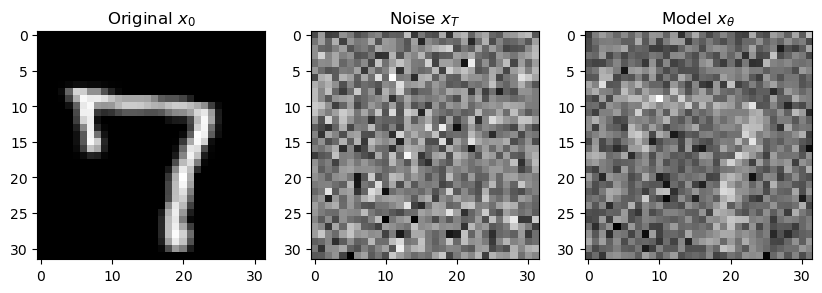

In [44]:
fig = plt.subplots(1,3,figsize=(10,6))
plt.subplot(1,3,1)
x_og = train_features[0].reshape(image_size,image_size)
plt.imshow(x_og,cmap='gray')
plt.title('Original $x_0$')

x = train_features[0].reshape(image_size,image_size)
betas = torch.linspace(1e-4, 0.02, time_steps)
x_noise, noise = model.forward_noise(train_features[0].reshape(image_size,image_size),time_steps,time_steps-1,betas)
plt.subplot(1,3,2)
plt.imshow(x_noise,cmap='gray')
plt.title('Noise $x_T$')
plt.subplot(1,3,3)
with torch.no_grad():
  for t in reversed(range(time_steps)):
    sqrt_recip_alphas_t = sqrt_recip_alphas[t]
    betas_t = betas[t]
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t]
    posterior_variance_t = posterior_variance[t]

    pred_noise, noise = model(x.reshape(1,1,image_size,image_size),torch.tensor([t]) )
    if t==0:
      noise = torch.zeros(x.shape)
    x = sqrt_recip_alphas_t * (x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t) + torch.sqrt(posterior_variance_t) * noise
    if t==0:
      noise = torch.zeros(x.shape)

  # pred_noise = model.unet(x.reshape(1,1,24,24),torch.tensor([betas[-1]]))
  # model_prediction = x - pred_noise
  # for t in reversed(range(time_steps-1)):
  #   pred_noise = model.unet(model_prediction,torch.tensor([betas[t]]))
  #   model_prediction = model_prediction - pred_noise
im = plt.imshow(x.reshape(image_size,image_size),cmap='gray')
plt.title(r'Model $x_\theta$')

# plt.colorbar(im)

# Discussion

### Forward Noising Process

A forward stochastic markov chain adds noise to the original data. This noising process aims to shift the distributions of each of the pixels to that of a normal distribution with a mean of zero and standard deviation of one.

<p align="center">
  <img src="images/forward_noising_process.png" alt="forward" width="1000"/>
</p>

### UNet

The UNet's job is to learn the noise distribution. In particular, it aims to learn the noise added in each time step by reversing the process during the reverse diffusion process. An example of a U-Net architecture is shown below (Credits: https://www.geeksforgeeks.org/u-net-architecture-explained/). This architecture consists of several convolutional blocks to downsample, or decrease the image size, and convolutional transpose blocks to upsample, or increase the image size.

<p align="center">
  <img src="images/unet.png" alt="unet" width="1000"/>
</p>

Below is an illustration of convolutional layers vs. convolutional tranpose layers. (Credits: https://hannibunny.github.io/mlbook/neuralnetworks/convolutionDemos.html)

**Convolutional Layer:** No padding of the image, stride of 1.

<!-- <p align="center">
  <img src="Convolution_arithmetic_-_No_padding_strides.gif" alt="attachment:Convolution_arithmetic_-_No_padding_strides.gif" width="400"/>
</p> -->

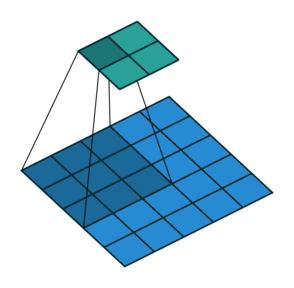

**Convolutional Layer:** Padding of the image, stride of 1.

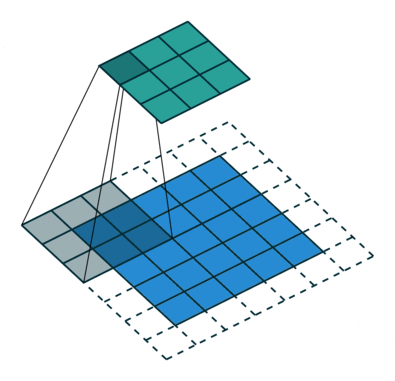

**Convolutional Transpose:** No padding of the image, stride of 1. (automatic increase in size the kernel runs over)

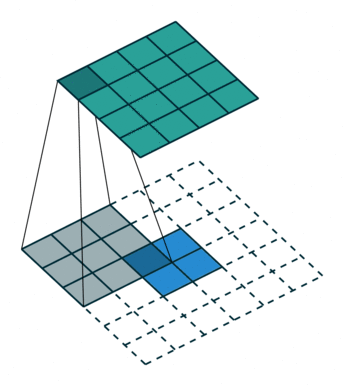

**Convolutional Transpose:** Padding of the image itself, stride of 1. (automatic increase in size the kernel runs over)

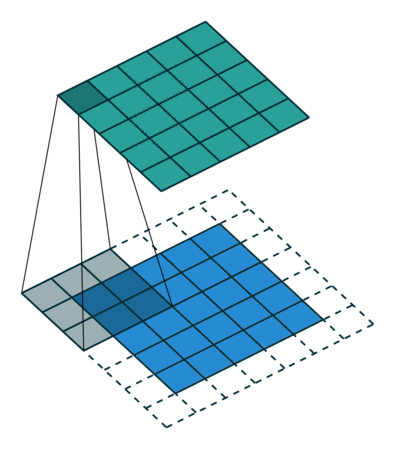

The key is that convolutional layers decrease the image size while convolutional transpose layers increase the image size. Note that convolutional transpose layers do not act as inverses to the convolutional layers.

<!-- <p align="center">
  <img src="backward_denoising_process.png" alt="backward" width="1000"/>
</p> -->

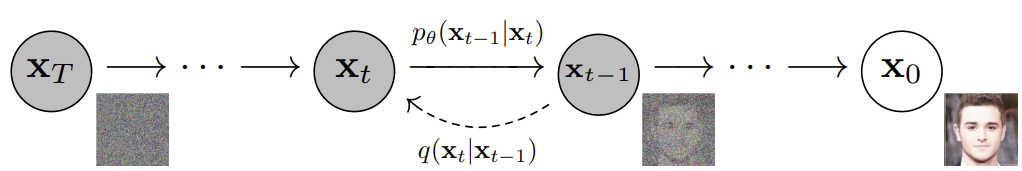

### Loss Function

There are two common ways to construct a loss function for a diffusion model. One way is to iterate the U-Net through all time steps from the noised image to the original image, therefore, the model outputs the cleaned images. In this case, you can use a mean-squared error (MSE) loss between the predicted and true image. A second way to randomly select a time step, construct the noised image at this step, then use the model to predict the noise input to the image at this step. Here, you can use an L1-loss squared or the MSE loss between the true and predicted noise, where information about the time step also must be included in the U-net. In both cases, the model is learning the noise distribution, i.e. how to denoise the images. The loss can be written as
$$L(\varepsilon,\varepsilon_\theta (x_t,t) ) = C\sum_{i,j} (\varepsilon_{ij} - \varepsilon_{\theta,ij} )^2$$
where $C$ is a constant.


# Other Resources



1.   Diffusion Models Beat GANs on Image Synthesis (OpenAI, 2021) https://arxiv.org/abs/2105.05233
2.   What are Diffusion Models? (Lilian Weng, 2021) https://lilianweng.github.io/posts/2021-07-11-diffusion-models/
3. Diffusion Models from Scratch in PyTorch: https://www.youtube.com/watch?v=a4Yfz2FxXiY
4. Transposed Convolution: https://www.youtube.com/watch?v=96_oGE8WyPg

